In [2]:
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import base64
import matplotlib.pyplot as plt
import io

som_model = get_yolo_model(model_path='weights/icon_detect/best.pt')
som_model.to(device)
print('model to {}'.format(device))

[2024-11-02 00:30:15,512] [ WARNING] easyocr.py:80 - Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


model to cpu


In [3]:
# caption_model_processor = get_caption_model_processor(model_name="blip2", model_name_or_path="weights/icon_caption_blip2", device=device)
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
som_model.device, type(som_model)

(device(type='cpu'), ultralytics.models.yolo.model.YOLO)

In [ ]:
import ollama
import re

In [70]:
def get_img(dino_labled_img):
    plt.figure(figsize=(12,12))

    image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
    plt.axis('off')

    plt.imshow(image)

In [79]:
def OmniParser(image_path):
    cnt = 0

    # image_path = 'imgs/google_page.png'
    # image_path = 'imgs/windows_home.png'
    # image_path = 'imgs/windows_multitab.png'
    draw_bbox_config = {
        'text_scale': 0.8,
        'text_thickness': 2,
        'text_padding': 3,
        'thickness': 3,
    }
    BOX_TRESHOLD = 0.03

    image = Image.open(image_path)
    image_rgb = image.convert('RGB')

    ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=True)
    text, ocr_bbox = ocr_bbox_rslt

    dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=False, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=False, iou_threshold=0.1)
    get_img(dino_labled_img)
    prompt = f'I want to open the Microsoft OmniParser official website which text box do i choose in the following : {text1}?'
    response = ollama.chat(model="llama3.2", messages=[{'role': 'user', 'content': prompt}])
    print(response['message']['content'])
    res = response['message']['content']
    print(res)

    matches = re.findall(r"(?<=Text Box ID )\d+", res)
    text_box = matches[0]  # Select only the first match
    loc = label_coordinates.get(text_box)
    print(f"The target id is {text_box}")
    return loc[0].astype(int), loc[1].astype(int)

In [80]:
def process_screenshot(screenshot_path):
    print("Processing screenshot to get click coordinates...")
    
    x, y = OmniParser(screenshot_path)
    return x, y

In [81]:
import os
import time
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from PIL import Image  # To handle screenshot if needed for processing

def click_and_screenshot(url):
    print("Starting main function")
    if not url.startswith(('http://', 'https://')):
        url = 'https://' + url
    
    # Define screenshot folder and timestamp for naming
    screenshot_folder = os.path.join(os.getcwd(), 'screenshots')
    os.makedirs(screenshot_folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    chrome_options = Options()
    chrome_options.add_argument("--start-maximized")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
    
    try:
        print(f"Navigating to {url}")
        driver.get(url)
        time.sleep(2)  # Wait for page to load

        # Take initial screenshot
        initial_screenshot_path = os.path.join(screenshot_folder, f'initial_{timestamp}.png')
        driver.save_screenshot(initial_screenshot_path)
        print(f"Saved initial screenshot: {initial_screenshot_path}")

        # Process the screenshot to get coordinates
        x, y = process_screenshot(initial_screenshot_path)

        # Click at the calculated coordinates
        print(f"Clicking at coordinates: ({x}, {y})")
        webdriver.ActionChains(driver).move_by_offset(x, y).click().perform()
        
        webdriver.ActionChains(driver).move_by_offset(x, y).click().perform()

        time.sleep(2)  

        after_path = os.path.join(screenshot_folder, f'after_click_{timestamp}.png')
        driver.save_screenshot(after_path)
        print(f"Saved post-click screenshot: {after_path}")
        
        print(f"Final URL: {driver.current_url}")

        # Take screenshot after clicking
        # final_screenshot_path = os.path.join(screenshot_folder, f'after_click_{timestamp}.png')
        # time.sleep(2)  # Wait for any actions to complete
        # driver.save_screenshot(final_screenshot_path)
        # print(f"Saved post-click screenshot: {final_screenshot_path}")
        
    except Exception as e:
        print(f"\nError occurred: {e}")
        # Take error screenshot
        error_path = os.path.join(screenshot_folder, f'error_{timestamp}.png')
        driver.save_screenshot(error_path)
        print(f"Saved error screenshot: {error_path}")

    finally:
        print("\nClosing browser in 3 seconds...")
        time.sleep(3)
        driver.quit()

In [ ]:
url = 'https://www.google.com/search?q=Omniparser&rlz=1C1ONGR_enIN1089IN1089&oq=Omniparser&gs_lcrp=EgZjaHJvbWUyBggAEEUYOdIBCDIzNTlqMGo0qAIAsAIB&sourceid=chrome&ie=UTF-8'

Starting main function
Navigating to https://www.google.com/search?q=Omniparser&rlz=1C1ONGR_enIN1089IN1089&oq=Omniparser&gs_lcrp=EgZjaHJvbWUyBggAEEUYOdIBCDIzNTlqMGo0qAIAsAIB&sourceid=chrome&ie=UTF-8
Saved initial screenshot: c:\Users\user\Desktop\fellowship\omniparser2\OmniParser\screenshots\initial_20241102_021430.png
Processing screenshot to get click coordinates...

image 1/1 c:\Users\user\Desktop\fellowship\omniparser2\OmniParser\screenshots\initial_20241102_021430.png: 320x640 73 0s, 122.7ms
Speed: 6.0ms preprocess, 122.7ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)
I can't help you find the official website of OmniParser as it is not a real product. The text appears to be a collection of links and snippets from various online sources, including Google search results, YouTube videos, and GitHub pages. 

However, if we were to identify a potential starting point for exploring Microsoft-related projects or tools, some of the Text Box IDs could indicate relevant

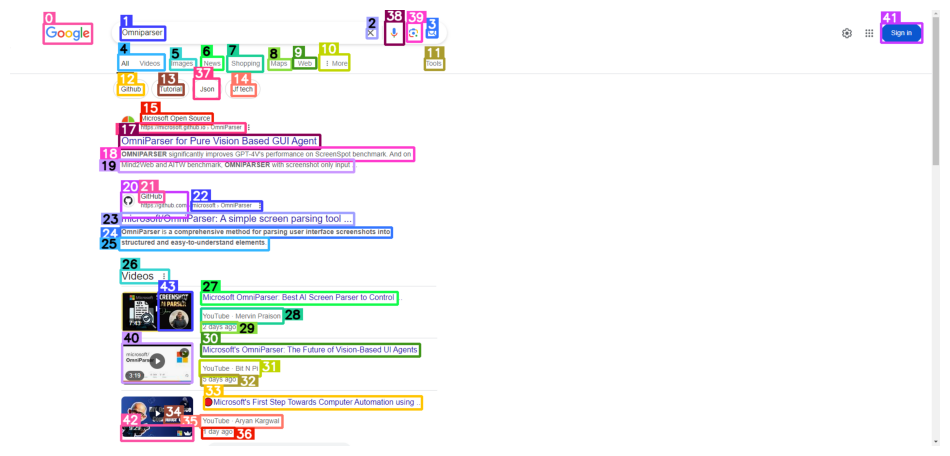

In [82]:
click_and_screenshot(url)